In [1]:
# imports
import matplotlib
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import zoom
import json
import warnings
from random import randint
import random
import SimpleITK as sitk
from multi_slice_viewer import multi_slice_viewer
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Conv3D, MaxPooling3D, Dropout, Conv3DTranspose, UpSampling3D, concatenate, Cropping3D, Reshape, BatchNormalization
import keras.callbacks
from keras import backend as K
from keras import optimizers
from keras import regularizers
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical
from IPython.display import clear_output
import pickle 

#this part is needed if you run the notebook on Cartesius with multiple cores
n_cores = 32
config = tf.ConfigProto(intra_op_parallelism_threads=n_cores-1, inter_op_parallelism_threads=1, allow_soft_placement=True)
session = tf.Session(config=config)
K.set_session(session)
os.environ["OMP_NUM_THREADS"] = str(n_cores-1)
os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

Using TensorFlow backend.


In [2]:
# Task03_liver dir in same directory as notebook
data_path = './Task03_Liver/'

In [3]:
# info about dataset in json file
with open(data_path + 'dataset.json') as f:
    d = json.load(f)   
    
    # paths to training set images with label
    train_paths = d['training']
    
    # paths to testset images with label
    test_paths = d['test'] 

In [5]:
# change to data dir 
os.chdir(data_path)
print(os.getcwd())

/nfs/home4/mbotros/ISMI_project/Task03_Liver


# Load the train set as SITK images

In [10]:
# load images and labels, loading all takes some time
train_imgs = [sitk.ReadImage(train_instance['image']) for train_instance in train_paths[:10]]
train_lbls = [sitk.ReadImage(train_instance['label']) for train_instance in train_paths[:10]]

In [11]:
# train images as numpy
np_train_imgs = [sitk.GetArrayFromImage(i) for i in train_imgs]
np_train_lbls = [sitk.GetArrayFromImage(i) for i in train_lbls]

# Spacing
Images do not have the same spacings. We will first resample. For this we need the spacings in the SITK images. Note that when converting sitk to numpy the z axis is placed at the front. Spacings in order: (x, y, z), numpy image: (z, x, y)

In [12]:
for image in train_imgs:
    print(image.GetSpacing())

(0.685546875, 0.685546875, 1.0)
(0.75390625, 0.75390625, 2.0)
(0.781000018119812, 0.781000018119812, 5.0)
(0.744140625, 0.744140625, 1.5)
(0.921875, 0.921875, 0.800000011920929)
(0.625, 0.625, 0.7989500164985657)
(1.0, 1.0, 1.0)
(0.7890625, 0.7890625, 0.699999988079071)
(0.7289999723434448, 0.7289999723434448, 0.800000011920929)
(0.8500000238418579, 0.8500000238418579, 4.0)


## Resampling
to 1mm x 1mm x 1mm resolution => images should have different sizes (not all 512 x 512 x N anymore). 
For example, when the image has a shape of (512, 512, 74) and a spacing of (0.75, 0.75, 2),
you can calculate how wide the image is along the x-axis: 512 * 0.75 mm = 384 mm. As a tip, look for “scipy zoom”.

In [13]:
def resample(np_imgs, spacings):
    """
    Resample to 1mm x 1mm x 1mm. 
    np_imgs: list of images or labels to be resampled as numpy
    spacings: spacings to resample with, order: (z, x, y)
    """ 
    resampled = []
    
    for i in range(len(np_imgs)): 
        # apply zoom with spacing, no clue what spline interpolation is
        resampled.append(zoom(np_imgs[i], spacings[i], order=1))

    return resampled

In [14]:
# store shapes before to check
shapes_before = [img.shape for img in np_train_imgs]

# spacings from sitk images
spacings = [img.GetSpacing() for img in train_imgs]

# change order
spacings = [(z, x, y) for x, y, z in spacings]          # order: (z, x, y)

In [15]:
# resample train images and labels
np_train_imgs = resample(np_train_imgs, spacings)
np_train_lbls = resample(np_train_lbls, spacings)

/hpc/sw/python-3.5.2/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [16]:
# lets print what happened.
print("Before\t\t\tSpacings\t\tAfter")
for i in range(len(np_train_imgs)):    
    # round for printing
    spacing_round = [(round(a, 1), round(b, 1), round(c, 1)) for a, b, c in spacings]    
    print("{}\t\t{}\t\t{}".format(shapes_before[i] , spacing_round[i], np_train_imgs[i].shape))

Before			Spacings		After
(588, 512, 512)		(1.0, 0.7, 0.7)		(588, 351, 351)
(245, 512, 512)		(2.0, 0.8, 0.8)		(490, 386, 386)
(94, 512, 512)		(5.0, 0.8, 0.8)		(470, 400, 400)
(424, 512, 512)		(1.5, 0.7, 0.7)		(636, 381, 381)
(845, 512, 512)		(0.8, 0.9, 0.9)		(676, 472, 472)
(513, 512, 512)		(0.8, 0.6, 0.6)		(410, 320, 320)
(200, 512, 512)		(1.0, 1.0, 1.0)		(200, 512, 512)
(908, 512, 512)		(0.7, 0.8, 0.8)		(636, 404, 404)
(856, 512, 512)		(0.8, 0.7, 0.7)		(685, 373, 373)
(105, 512, 512)		(4.0, 0.9, 0.9)		(420, 435, 435)


## Save resampled data as pickle and load
I put this in the Task03_liver folder

In [17]:
with open('./data_liver.pickle', 'wb') as handle:
    pickle.dump({'images': np_train_imgs, 'labels': np_train_lbls}, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
print(os.getcwd())
with open('./data_liver.pickle', 'rb') as handle:
    data = pickle.load(handle)
np_train_imgs = data['images']
np_train_lbls = data['labels']

/nfs/home4/mbotros/ISMI_project/Task03_Liver


## Make the labels binary
Because it's hard to make a dice for 3 labels, we remove the cancer labels for now.

In [7]:
np_train_lbls = [np.where(lbl != 2, lbl, 1) for lbl in np_train_lbls]

## Do we have imbalances in our data? 

In [8]:
# count the labels of train images
sums = np.zeros(3)
for lbs in np_train_lbls:
    labels, counts = np.unique(lbs, return_counts=True)
    
    # if there are only 2 labels
    if len(counts) == 2:
        sums[:2]+=counts
    else:
        sums+=counts

In [9]:
# print percentages of voxels.
total = sum(sums)
print("{:.2f}% background, {:.2f}% liver, {:.2f}% cancer.".format(sums[0]/total*100, sums[1]/total*100, sums[2]/total*100))

97.98% background, 2.02% liver, 0.00% cancer.


In [10]:
class DataSet:
    
    def __init__(self, imgs, lbls=None):
        self.imgs = imgs
        self.lbls = lbls
    
    def get_lenght(self):
        return len(self.imgs)
    
    def show_image(self, i):
        if self.lbls != None: 
            plt.rcParams['figure.figsize'] = [8, 8]
            multi_slice_viewer(self.imgs[i], view='axial', overlay_1=self.lbls[i], overlay_1_thres=1, 
                   overlay_2=self.lbls[i], overlay_2_thres=2, overlay_2_cmap='coolwarm', overlay_2_alpha=0.75)
        else:
            plt.rcParams['figure.figsize'] = [8, 8]
            multi_slice_viewer(self.imgs[i], view='axial')  

# Split for training and validation

In [12]:
# make a small data set of training images, as numpy
validation_percent = 0.2 # coefficient to define validation dataset (value between 0 and 1)
n_validation_imgs = int(validation_percent * len(np_train_imgs))

train_set = DataSet(np_train_imgs[:n_validation_imgs], np_train_lbls[:n_validation_imgs])
val_set   = DataSet(np_train_imgs[n_validation_imgs:], np_train_lbls[n_validation_imgs:])

# Patch extractor
We re-use the patch extractor from assignment 7, but modify it to get 3D patches from a 3D image.
We can add augmentations later in the patch extractor. Note the extra dimension in the shape of patch_out and target_out. This doesn't work if the patch size doesn't fit in the image.

In [13]:
class PatchExtractor:

    def __init__(self, patch_size):
        self.patch_size = patch_size 
    
    def get_patch(self, image, label):
        ''' 
        Get a 3D patch of patch_size from 3D input image, along with corresponding 3D label map.
        Pick random location of the patch inside the image. The point is at the center of the patch.
        We first pad the image to not go out of bounds when extracting the patch.
        image: a numpy array representing the input image
        label: a numpy array representing the labels corresponding to input image
        '''
        
        # size of patch in each dimension
        pz, px, py = self.patch_size
        
#         print('Patch_size: {}'.format(patch_size))
#         print('Image_size: {}'.format(image.shape))

        # pad with the min value in the image
        min_val = np.min(image)
        
        # pad with half the patch size, I assume even patch size
        padded_img = np.pad(image, ((pz//2, pz//2), (px//2, px//2), (py//2, py//2)), 'constant', constant_values=min_val)
        padded_lbl = np.pad(label, ((pz//2, pz//2), (px//2, px//2), (py//2, py//2)), 'constant')
        
#         print('Padded_size: {}'.format(padded_img.shape))
        
        # centre of the patch: a random location in the non padded image
        # z,x,y is the left bottom corner of the patch in the padded image (index shift with pad size)
        dims = image.shape           
        z = randint(0, dims[0]) 
        x = randint(0, dims[1]) 
        y = randint(0, dims[2])       

        # take a patch, with the random point at the center in the padded img
        patch  = padded_img[z:z+pz, x:x+px, y:y+py].reshape(pz, px, py, 1)
        target = padded_lbl[z:z+pz, x:x+px, y:y+py].reshape(pz, px, py, 1)

        return patch, target

(132, 132, 132, 1)
(132, 132, 132, 1)


<IPython.core.display.Javascript object>


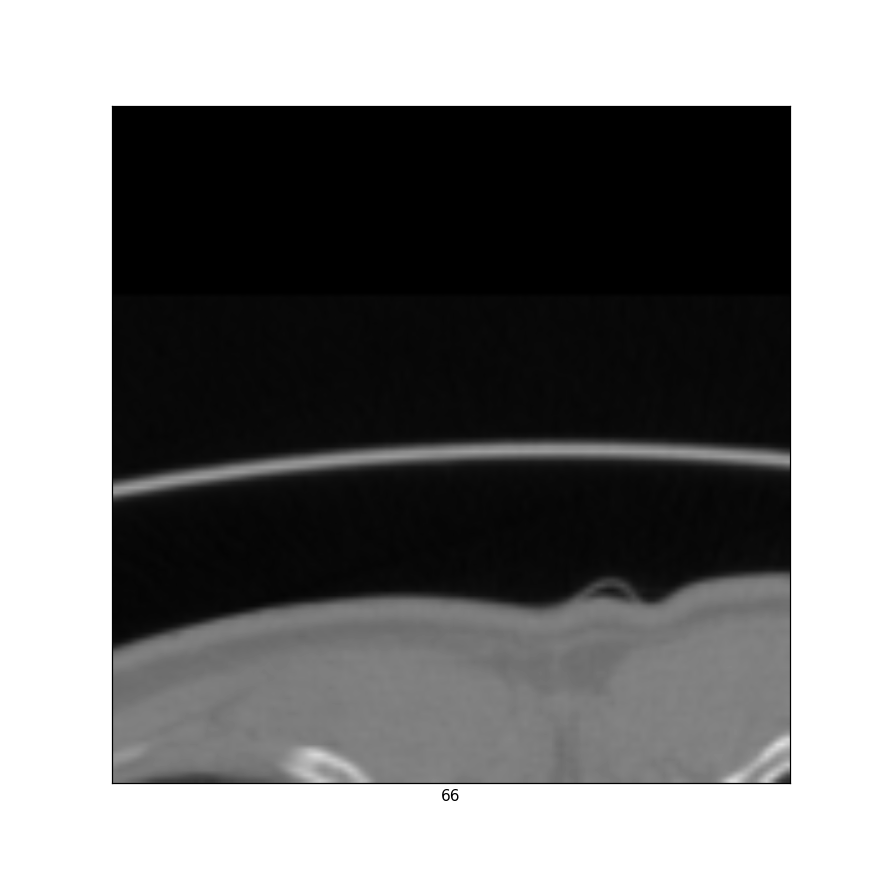

In [14]:
# get an image and a label from our train set
image = train_set.imgs[0]
label = train_set.lbls[0]

# test PatchExtractor
patch_size = (132, 132, 132)
patch_extractor = PatchExtractor(patch_size=patch_size)

# lets check some patches
patch, target = patch_extractor.get_patch(image, label)

print(patch.shape)
print(target.shape)

# show patch
plt.rcParams['figure.figsize'] = [8, 8]            
multi_slice_viewer(patch.reshape(patch_size), view='axial', overlay_1=target.reshape(patch_size), overlay_1_thres=1, 
                   overlay_2=target.reshape(patch_size), overlay_2_thres=2, overlay_2_cmap='coolwarm', overlay_2_alpha=0.75)

# Batch creator
Lets also reuse the batch creator from assignment 7. We are going to use valid convolutions, which means the output of our network will be smaller than the input. The purpose of this batchcreator is the make batches consisting of patches with their corresponding labels (for the network to train on). Since a UNet with valid convolutions has a smaller output than input, we need to crop the label based on the target size aswell. And labels should be in onehot.

In [15]:
class BatchCreator:
    
    def __init__(self, patch_extractor, dataset, target_size):
        self.patch_extractor = patch_extractor
        self.target_size = target_size # size of the output, can be useful when valid convolutions are used        
        self.imgs = dataset.imgs
        self.lbls = dataset.lbls                
        self.n = len(self.imgs)
        self.patch_size = self.patch_extractor.patch_size
    
    def create_image_batch(self, batch_size):
        '''
        returns a single (batch of?) patches (x) with corresponding labels (y) in one-hot structure
        '''
        x_data = np.zeros((batch_size, *self.patch_extractor.patch_size, 1))  # 1 channel
        y_data = np.zeros((batch_size, *self.target_size, 2)) # one-hot encoding with 2 classes
        
        for i in range(0, batch_size):
        
            random_index = np.random.choice(len(self.imgs))                   # pick random image
            img, lbl = self.imgs[random_index], self.lbls[random_index]       # get image and segmentation map
            
            # clip values outside [-1000, 3000] and normalize image intensity to range [0., 1.]      
            img = np.clip(img, -1000, 3000)
            img = (img - np.min(img)) / np.ptp(img)     
            
            # get a patch with corresponding labels from the patch extractor
            patch_img, patch_lbl = self.patch_extractor.get_patch(img, lbl)   
            
            # crop labels based on target_size           
            ph = (self.patch_extractor.patch_size[0] - self.target_size[0]) // 2    
            pw = (self.patch_extractor.patch_size[1] - self.target_size[1]) // 2
            pd = (self.patch_extractor.patch_size[2] - self.target_size[2]) // 2
            
            # take the cropped patch, it contains labels with values 0,1,2
            cropped_patch = patch_lbl[ph:ph+self.target_size[0], pw:pw+self.target_size[1], pd:pd+self.target_size[2]].squeeze() 
            
            # instead of 0,1,2 label values we want categorical/onehot => 0: [1, 0, 0], 1: [0, 1, 0], 2: [0, 0, 1]
            onehot = to_categorical(cropped_patch, num_classes=2)
            
            x_data[i, :, :, :, :] = patch_img
            y_data[i, :, :, :, :] = onehot
        
        return (x_data.astype(np.float32), y_data.astype(np.float32))
    
    def get_image_generator(self, batch_size):
        '''returns a generator that will yield image-batches infinitely'''
        while True:
            yield self.create_image_batch(batch_size)

# 3D UNet Model
Start with this model, we can adapt this later if needed. Build like the net from: 
3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation. Ozgun Cicek et al, 2016.

In [32]:
# make block of two convolve3D's
def unet_block(inputs, n_filters, padding, up_conv=False, batchnorm=False):
    # 3d convolve, 32 3x3x3 filters 
    c1 = Conv3D(n_filters, (3,3,3), activation='relu', padding=padding)(inputs)
    if batchnorm:
        c1 = BatchNormalization()(c1)
    
    # up conv (normal conv in the expanding path) has same number of filters twice
    if up_conv:
        c2 = Conv3D(n_filters, (3, 3, 3), activation='relu', padding=padding)(c1)
    else:          # normal convs have twice the filters in the second conv
        c2 = Conv3D(n_filters*2, (3, 3, 3), activation='relu', padding=padding)(c1)
        
    if batchnorm:
        c2 = BatchNormalization()(c2)
    
    return c2

In [35]:
# 3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation. Ozgun Cicek et al, 2016.
def build_unet_3d(initial_filters, padding, batchnorm=True):
    
    ## CONTRACTING PATH

    # (spac_dim_1, space_dim_2, space_dim_3, channels)
    inputs = Input(shape=(132, 132, 132, 1))

    # First conv pool, 32 filters and 64 filters    
    block_1    = unet_block(inputs, initial_filters, padding=padding, batchnorm=batchnorm) 
    max_pool_1 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(block_1)  # 2×2×2 max pooling with strides two
                                                                        # needs even spacial_dimensions as input
    # second conv pool, 64 filters, 128 filters    
    block_2    = unet_block(max_pool_1, initial_filters*2, padding=padding, batchnorm=batchnorm)
    max_pool_2 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(block_2)
    
    # third conv pool, 128 filters, 256 filters    
    block_3    = unet_block(max_pool_2, initial_filters*4, padding=padding, batchnorm=batchnorm)
    max_pool_3 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(block_3)
    
    # just a conv block without maxpooling, 256 filters and 512 filters
    conv_4     = unet_block(max_pool_3, initial_filters*8, padding=padding, batchnorm=batchnorm)
    
    ## EXPANDING PATH   
    
    #TODO: check Conv3DTranspose correctly applied
    
    # round 1
    up_conv_3  = Conv3DTranspose(16*initial_filters, (2, 2, 2), strides=(2, 2, 2), padding=padding)(conv_4)
    crop_3     = Cropping3D(cropping=4)(block_3) 
    concat_3   = concatenate([crop_3, up_conv_3])  
    up_block_3 = unet_block(concat_3, 8*initial_filters, padding, up_conv=True, batchnorm=batchnorm)
    
    # round 2
    up_conv_2  = Conv3DTranspose(8*initial_filters, (2, 2, 2), strides=(2, 2, 2), padding=padding)(up_block_3) 
    crop_2     = Cropping3D(cropping=16)(block_2) 
    concat_2   = concatenate([crop_2, up_conv_2])  
    up_block_2 = unet_block(concat_2, 4*initial_filters, padding, up_conv=True, batchnorm=batchnorm)
    
    # round 3
    up_conv_1  = Conv3DTranspose(4*initial_filters, (2, 2, 2), strides=(2, 2, 2), padding=padding)(up_block_2) 
    crop_1     = Cropping3D(cropping=40)(block_1) 
    concat_1   = concatenate([crop_1, up_conv_1])  
    up_block_1 = unet_block(concat_1, 2*initial_filters, padding, up_conv=True, batchnorm=batchnorm)
    
    # finish with 1x1x1 conv, 3 filters, # labels, softmax or ReLU?
    finish = Conv3D(2, (1,1,1), activation='softmax', padding=padding)(up_block_1)
    
    model = Model(inputs, finish) 
    print(model.summary(line_length=150))
    
    return model

In [36]:
unet_3d = build_unet_3d(initial_filters=32, padding='valid')

______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_3 (InputLayer)                             (None, 132, 132, 132, 1)         0                                                                   
______________________________________________________________________________________________________________________________________________________
conv3d_17 (Conv3D)                               (None, 130, 130, 130, 32)        896               input_3[0][0]                                     
______________________________________________________________________________________________________________________________________________________
batch_normalization_15 (BatchNormalization)      (None, 130, 130, 130, 32)        128         

In [19]:
# Not sure how this still isn't exactly the same parameters as the paper (19,069,955). Close enough tho.

## Testing the batch generator

In [60]:
# define parameters for the batch creator
patch_size  = (132, 132, 132)  # isotropic patch size
target_size = (44, 44, 44)     # output size, smaller since valid convolutions are used
batch_size  = 1                # number of patches in a mini-batch, for segmentation 1 is fine, since the 
                               # output of the net is many thousands of values per patch, which all contribute to the loss

# initialize patch generator and batch creator
patch_generator       = PatchExtractor(patch_size)
batch_generator_train = BatchCreator(patch_generator, train_set, target_size=target_size)
batch_generator_val   = BatchCreator(patch_generator, val_set, target_size=target_size)

# get one minibatch
x_data, y_data = batch_generator_train.create_image_batch(batch_size)

print("(batch, d, h, w, channels)")
print('xdata has shape: {}'.format(x_data.shape))
print('ydata has shape: {}'.format(y_data.shape))
print('Occuring values in true labels: {}'.format(np.unique(y_data)))
print('Min of input: {}'.format(np.min(x_data)))
print('Max of input: {}'.format(np.max(x_data)))

(batch, d, h, w, channels)
xdata has shape: (1, 132, 132, 132, 1)
ydata has shape: (1, 44, 44, 44, 2)
Occuring values in true labels: [0. 1.]
Min of input: 0.0
Max of input: 0.6544322371482849


## Define a logger which saves the losses and saves the best model

In [93]:
class Logger(keras.callbacks.Callback):

    # logg losses and accs, add dice later
    def __init__(self, data_dir, model_name):  
        self.model_filename = os.path.join(data_dir, model_name + '.h5')        
        self.tr_losses = []  
        self.tr_accs = []
        self.val_losses = []  
        self.val_accs = []     
        self.best_val_loss = float("inf") 
        self.best_model = None     
       
    def on_epoch_end(self, batch, logs={}):
        # add validation info
        self.val_losses.append(logs.get('val_loss'))
        self.val_accs.append(logs.get('val_accuracy')) 
        self.tr_losses.append(logs.get('loss'))
        self.tr_accs.append(logs.get('accuracy')) 
        self.plot()

        # safe best model after epoch end
        if self.val_losses[-1] < self.best_val_loss:
            self.best_val_loss = self.val_losses[-1]
            self.model.save(self.model_filename) # save best model to disk
            print('Best model saved as {}'.format(self.model_filename))
         
    def plot(self): 
        clear_output()
        plt.figure(figsize=(8, 4))
        n = len(self.val_losses) + 1         
        plt.plot(range(1, n), self.tr_losses, label='train loss')         
        plt.plot(range(1, n), self.tr_accs, label='train accuracy')
        plt.plot(range(1, n), self.val_losses, label='val loss')        
        plt.plot(range(1, n), self.val_accs, label='val accuracy') 
        plt.legend(loc='lower left')
        plt.show()

## Now we define parameters, compile the model and train the network 

In [94]:
# make a data dir to store best model
data_dir = '../data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [95]:
# back to inline, I don't know how to plot in notebook mode
%matplotlib inline

## Dice Loss
Dice loss seems to be a good pick for 3D segmentation with class inbalances. We have to look if this works like this.
In our case y_pred is output of the softmax.
(see https://arxiv.org/pdf/1707.03237.pdf)

In [130]:
# https://gist.github.com/jeremyjordan/9ea3032a32909f71dd2ab35fe3bacc08
def soft_dice_loss(y_true, y_pred, epsilon=1e-6): 
    ''' 
    Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
    Assumes the channels_last format.
  
    # Arguments
        y_true:  One hot encoding of ground truth
        y_pred:  Network output, must sum to 1 over c channel (such as after softmax) 
        epsilon: Used for numerical stability to avoid divide by zero errors
    
    # References
        V-Net: Fully Convolutional Neural Networks for Volumetric Medical Image Segmentation 
        https://arxiv.org/abs/1606.04797
        More details on Dice loss formulation 
        https://mediatum.ub.tum.de/doc/1395260/1395260.pdf (page 72)        
        Adapted from https://github.com/Lasagne/Recipes/issues/99#issuecomment-347775022
        Apapted for Keras backend.
    '''
    
    print(y_true.shape)
    print(y_pred.shape)
    
    # skip the batch and class axis for calculating Dice score
    axes = tuple(range(1, len(y_pred.shape) - 1)) 
    
    print(axes)
    
    numerator = 2. * K.sum(y_pred * y_true, axes)                       # intersection
    denominator = K.sum(np.square(y_pred) + y_true, axes)               # square predicted probabilities =? soft loss
    return 1 - K.mean(numerator / (denominator + epsilon))              # average over classes and batch


In [127]:
def dice_loss(y_true, y_pred, epsilon=1e-6):
    ''' 
        y_true: One hot encoding of ground truth
        y_pred: Network output, must sum to 1 over c channel (such as after softmax) 
    '''
    print(y_true.shape)
    print(y_pred.shape)
#     y_true = K.flatten(y_true)
#     y_pred = K.flatten(y_pred)

    # average over batches and classes? sum of axis 1,2,3 and take mean
    axes = (1, 2, 3)
    # compute intersection
    intersect = K.sum(y_true * y_true, axis=axes)
    
    # y_pred are probabilties so this is kinda meh, we would want y_pred in onehot but cant use argmax
    return 1 - K.mean((2 * intersect + epsilon) / (K.sum(y_true, axis=axes) + K.sum(y_pred, axis=axes) + epsilon)) 

In [131]:
learning_rate   = 0.01
optimizer       = SGD(lr=learning_rate, momentum=0.9, nesterov=True)
#optimizer       = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
metrics         = ['accuracy']  # probably not useful (?)
steps_per_epoch = 5
epochs          = 5
logger          = Logger(data_dir, '3D_UNet')

image_generator_train = batch_generator_train.get_image_generator(batch_size)
image_generator_val   = batch_generator_val.get_image_generator(batch_size)

# get one trainbatch
# x_data, y_data = batch_generator_train.create_image_batch(batch_size)
# print("We throw in data with shape:{}".format(x_data.shape))
# print("and labels with shape:{}".format(y_data.shape))

# compile model
unet_3d.compile(optimizer=optimizer, loss=soft_dice_loss, metrics=metrics)

(?, ?, ?, ?, ?)
(?, 44, 44, 44, 2)
(1, 2, 3)


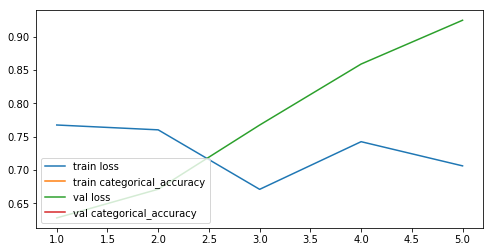

In [132]:
# train the model
unet_3d.fit_generator(generator=image_generator_train, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=epochs, 
                    validation_data=image_generator_val,
                    validation_steps=5,
                    callbacks=[logger])

## Getting the full segmentation map
Like this but then 3D:

![seg_diagram.png](seg_diagram.png)


In [35]:
def padding(image, patch_size, target_size):
    """
    Adding the red border (see example above) to the image. Which is needed for when we don't have full context. 
    Pad with lowest occuring values.
    image       : the input image (as numpy)
    patch_size  : patch_size of the input for the UNet
    target_size : output size of the model, needed to calculate how much to padd in each dimension. 
    """
    z, y, x = patch_size
    
    # pad with min value from image, always safe
    min_val = np.min(image)
    
    # size of padding for each dimension
    pad_z = (z - target_size[0]) // 2
    pad_x = (x - target_size[1]) // 2
    pad_y = (y - target_size[2]) // 2
    
    # pad with a tuple for how much on each side for every dimension
    padded_input = np.pad(image, ((pad_z, pad_z), (pad_x, pad_x), (pad_y, pad_y)), 'constant', constant_values=min_val)
    
    return padded_input

In [36]:
def predict_image_segmentation(model, image, target_size, patch_size):
    """
    Give a full segmentation map (same size as input_image) using the model. 
    model       : the model to do the prediction
    image       : the input image (as numpy)
    target_size : output size of the model (since we use valid convutions the output gets smaller)
    patch_size: : the size of the patch that is put into the model
    """
    
    # clip values outside [-1000, 3000] and normalize image intensity to range [0., 1.]      
    image = np.clip(image, -1000, 3000)
    image = (image - np.min(image)) / np.ptp(image)    
    
    # pad the input image:
    pad_img = padding(image, patch_size, target_size)  

    print("Image size: {}".format(image.shape))
    print("Padded image size: {}".format(pad_img.shape))
    
    dims = image.shape
    # how many times target size fits in a dimension 
    pz = dims[0] // target_size[0] 
    px = dims[1] // target_size[1] 
    py = dims[2] // target_size[2] 
    
    # segmentation map, same size as input image
    segmentation = np.zeros(image.shape)   
       
    for z in range(pz):         
        for x in range(px):
            for y in range(py):  
                
                # shift starting point with target_size
                start_z = z * target_size[0]
                start_x = x * target_size[1]
                start_y = y * target_size[2]
                
                # Get patch: shift with target_size, take patch_size                
                patch = pad_img[start_z:start_z + patch_size[0], 
                                start_x:start_x + patch_size[1], 
                                start_y:start_y + patch_size[2]]     
                
                # Reshape for u-net and make prediction:
                patch = np.reshape(patch, (1, patch_size[0], patch_size[1], patch_size[2], 1))
                prediction = model.predict(patch)
                
                # Put the prediction in segmentation map, shift with target_size, take target_size
                segmentation[start_z:start_z + target_size[0], 
                             start_x:start_x + target_size[1], 
                             start_y:start_y + target_size[2]] = np.argmax(np.squeeze(prediction), axis=3)
    
    return segmentation 

In [65]:
# take an image and a label from validation set
image = train_set.imgs[2][200:400, :, -200:]
label = train_set.lbls[2][200:400, :, -200:]
patch_size  = (132, 132, 132)  
target_size = (44, 44, 44)    
print(image.shape)

(200, 400, 200)


In [ ]:
# load best model
# unet_3d = load_model(os.path.join(data_dir, '3D_UNet' + '.h5'))

In [67]:
segmentation = predict_image_segmentation(unet_3d, image, target_size, patch_size)

Image size: (200, 400, 200)
Padded image size: (288, 488, 288)


In [68]:
print(np.unique(segmentation, return_counts=True))

(array([0., 1., 2.]), array([ 4627131, 11346543,    26326]))


In [61]:
%matplotlib notebook

<IPython.core.display.Javascript object>


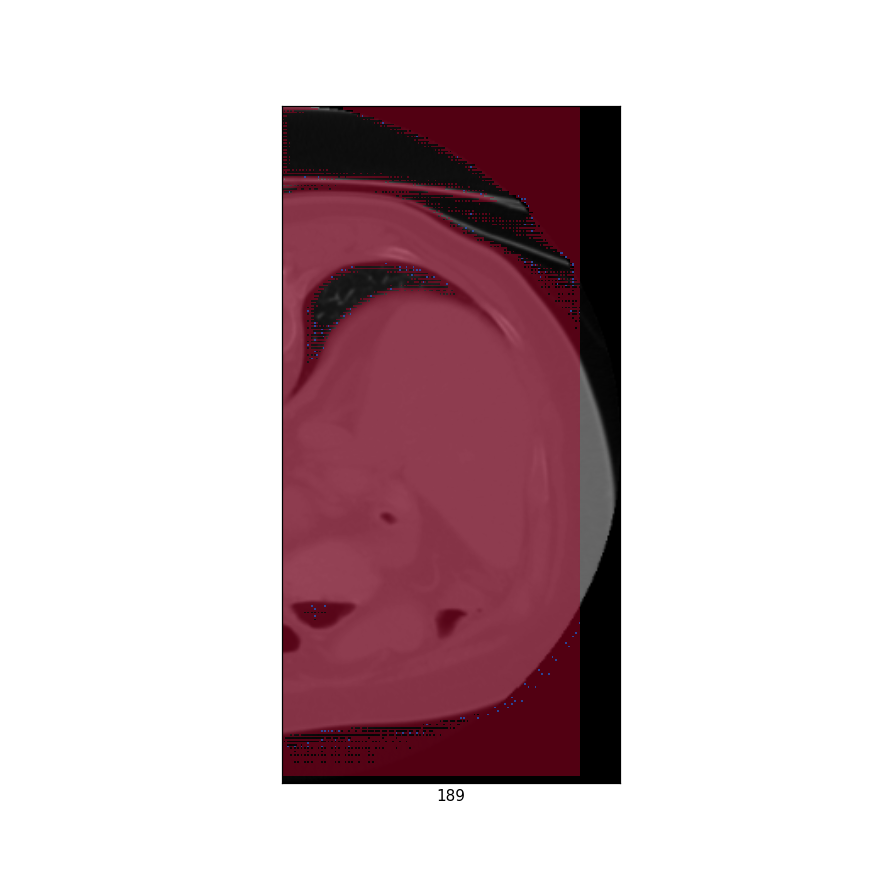

In [69]:
# show segmentation
plt.rcParams['figure.figsize'] = [8, 8]            
multi_slice_viewer(image, view='axial', overlay_1=segmentation, overlay_1_thres=1, 
                   overlay_2=segmentation, overlay_2_thres=2, overlay_2_cmap='coolwarm', overlay_2_alpha=0.75)

<IPython.core.display.Javascript object>


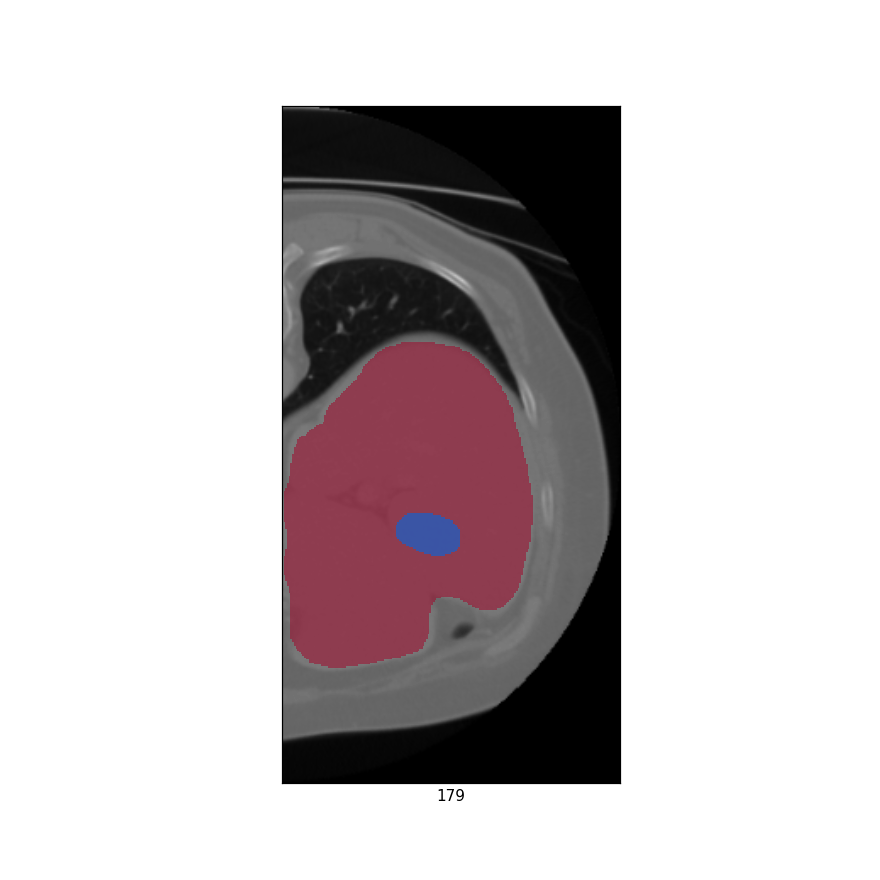

In [66]:
# show ground truth
plt.rcParams['figure.figsize'] = [8, 8]            
multi_slice_viewer(image, view='axial', overlay_1=label, overlay_1_thres=1, 
                   overlay_2=label, overlay_2_thres=2, overlay_2_cmap='coolwarm', overlay_2_alpha=0.75)

## TODO: 
* Segmentation for the last parts.
* Validate with dice on full images after each epoch => save model which does best for the whole validation set.